# Run PhyloVelo in simulation data

This notebook will show you the basic usage of PhyloVelo and simulation of scRNA data. In this tutorial, we will use the lineage tree generated in the previous section to first simulate scRNA count data for linear, bifurcated and convergent models, and then analyze and present the results using _PhyloVelo_

In [1]:
import os
os.chdir('../../../demo/datasets/')

In [2]:
import phylovelo as pv
import pandas as pd
import matplotlib.pyplot as plt

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Linear model

### Load simulated lineage infomation and reconstruct lineage tree

In [3]:
# tree_file = './Linear/tree_origin_var0.02_rvg0.05.csv0'
# reconstruct('./Linear/'+tree_file, output='./Linear/'+tree_file+'.nwk', num=1000, is_balance=True)

### Load reconstructed tree and cell information

In [5]:
tree_file = './Linear/tree_origin_var0.02_rvg0.05.csv0.nwk'
phylo_tree, branch_colors = pv.ana_utils.loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = pv.sim_utils.get_annotation('./Linear/tree_origin_var0.02_rvg0.05.csv0')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

In [6]:
sd = pv.data_struct.scData(phylo_tree=phylo_tree, 
                            cell_states=cell_states.to_numpy().T[0].astype('int'), 
                            cell_generation=cell_generation.T[0].astype('int'),
                            cell_names=sampled_cells)

### Simulate single cell base expression matrix

In [7]:
ge, base_expr = pv.sim_utils.sim_base_expr(sd.phylo_tree, 
                                             cell_states,
                                             Ngene=2000, 
                                             r_variant_gene=0.4, 
                                             diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                             forward_map={},
                                             mu0_loc=0, 
                                             mu0_scale=1, 
                                             drift_loc=0, 
                                             drift_scale=0.3,
                                            )

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  base_expr[cell.name] = ge.expr(


### Add lineage noise and drawn count from base expression

In [8]:
sd.count = pv.sim_utils.get_count_from_base_expr(pv.sim_utils.add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.1)

### tSNE embedding and visualization

In [9]:
sd.dimensionality_reduction()

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


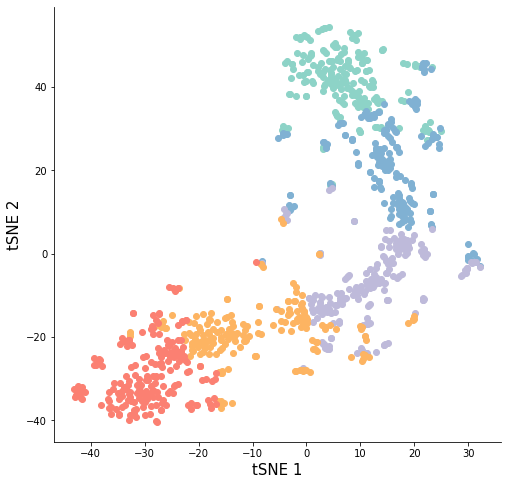

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Normalize data and filter genes with low expression

In [11]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

### Phylogenetic velocity inference and project velocity into embedding. For simulation data, ZINB model is used to analyze

In [12]:
sd = pv.inference.velocity_inference(sd, sd.cell_generation, cutoff=0.9, target='count', exact=True)
sd = pv.embedding.velocity_embedding(sd, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:333: RuntimeWarning: invalid value encountered in log
  y = np.log(y + 1)


### Show results

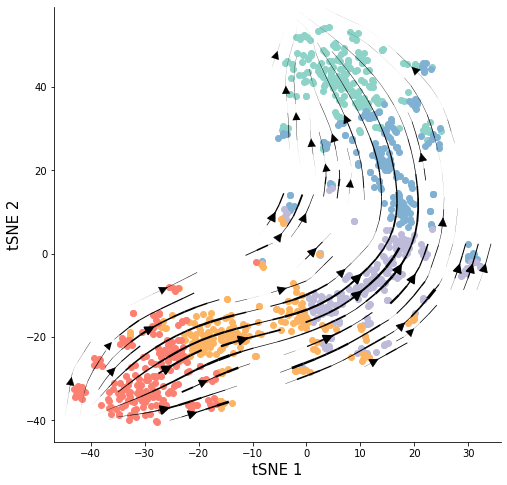

In [13]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

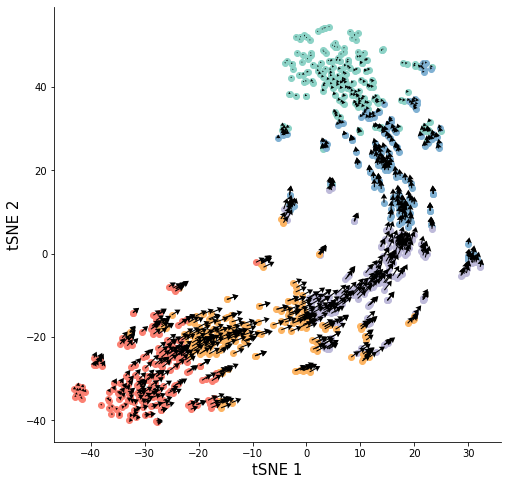

In [14]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'point', headwidth=6)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Overlap of MEGs and PhyloVelo detected MEGs
MEGs were determined using the drift coefficients from the scRNA simulation program. To ensure that MEGs are detectable, we only refer to genes with absolute values of drift coefficients greater than 0.2 as MEG.

In [30]:
from matplotlib_venn import venn3
from scipy.stats import spearmanr
import numpy as np

drifts = pd.DataFrame(data=np.array([np.array([ge.cells[ct][g].drift for ct in range(5)]) for g in range(2000)]), index=range(2000))
megs = set(np.arange(2000)[drifts.apply(lambda x: (np.all(x<0) or np.any([np.all(x[:i]<0)&np.all(x[i:]>0) for i in range(5)]))&(abs(x[4])>0.2), axis=1)])

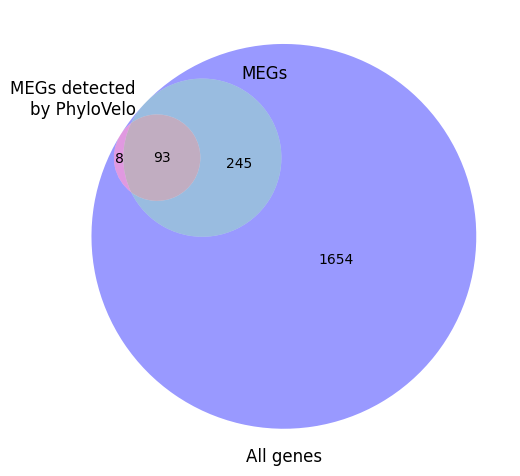

In [36]:
plt.figure(figsize=(6,6), dpi=100)
genesets = [set(sd.clock_genes), megs, set(range(2000))]
g = venn3(subsets=genesets, 
          set_labels=('MEGs detected\nby PhyloVelo', 'MEGs', 'All genes'))

### Simulate mutation tree
All branch length is rescaled by a poisson distribution. Here, we show the results with a mutation rate of 0.3 as an example

In [38]:
from copy import deepcopy
mut_rate = 0.3

mutation_tree = deepcopy(sd.phylo_tree)
for i in mutation_tree.get_nonterminals():
    i.branch_length = np.random.poisson(mut_rate)

for i in mutation_tree.get_terminals():
    i.branch_length = np.random.poisson(mut_rate)
    
depths1 = np.array([mutation_tree.depths()[mutation_tree.find_any(name=i)] for i in sd.count.index])

In [40]:
sd = pv.inference.velocity_inference(sd, depths1, cutoff=0.9, target='count', exact=True)
sd = pv.embedding.velocity_embedding(sd, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:333: RuntimeWarning: invalid value encountered in log
  y = np.log(y + 1)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)


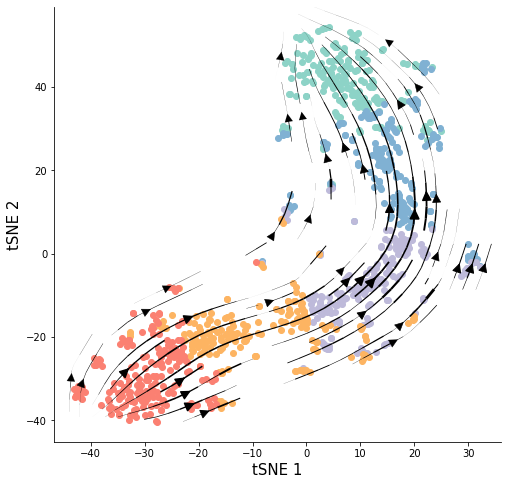

In [41]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Bifurcated model

In [ ]:
# tree_file = './Bifurcated/tree_origin_var0.02_rvg0.05.csv0'
# reconstruct('./Bifurcated/'+tree_file, output='./Linear/'+tree_file+'.nwk', num=1000, is_balance=True)

In [43]:
tree_file = './Bifurcated/tree_origin_var0.02_rvg0.05.csv0.nwk'
phylo_tree, branch_colors = pv.ana_utils.loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = pv.sim_utils.get_annotation('./Bifurcated/tree_origin_var0.02_rvg0.05.csv0')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

In [44]:
sd = pv.data_struct.scData(phylo_tree=phylo_tree, 
                            cell_states=cell_states.to_numpy().T[0].astype('int'), 
                            cell_generation=cell_generation.T[0].astype('int'),
                            cell_names=sampled_cells)

In [47]:
ge, base_expr = pv.sim_utils.sim_base_expr(sd.phylo_tree, 
                                             cell_states,
                                             Ngene=2000, 
                                             r_variant_gene=0.4, 
                                             diff_map={0:[0],1:[0],2:[0],3:[1],4:[1]},
                                             pseudo_state_time={0:[0,5], 1:[7,12], 2:[7,12], 3:[13,18], 4:[13,18]},
                                             forward_map = {},
                                             mu0_loc=0, 
                                             mu0_scale=1, 
                                             drift_loc=0, 
                                             drift_scale=0.3,
                                         )

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  base_expr[cell.name] = ge.expr(


In [55]:
sd.count = pv.sim_utils.get_count_from_base_expr(pv.sim_utils.add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.05)
sd.dimensionality_reduction(methor='tsne', scale=1, n_highly_variable_genes=0, perplexity=50, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 'tSNE 2')

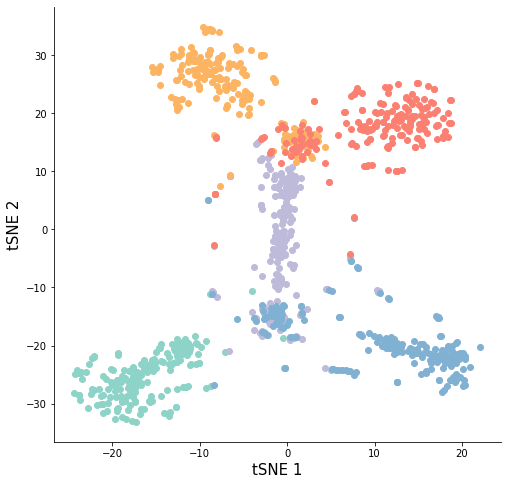

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)

In [57]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

In [58]:
sd = pv.inference.velocity_inference(sd, sd.cell_generation, cutoff=0.9, target='count', exact=True)
sd = pv.embedding.velocity_embedding(sd, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:333: RuntimeWarning: invalid value encountered in log
  y = np.log(y + 1)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: divide by zero encountered in log
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in multiply
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)


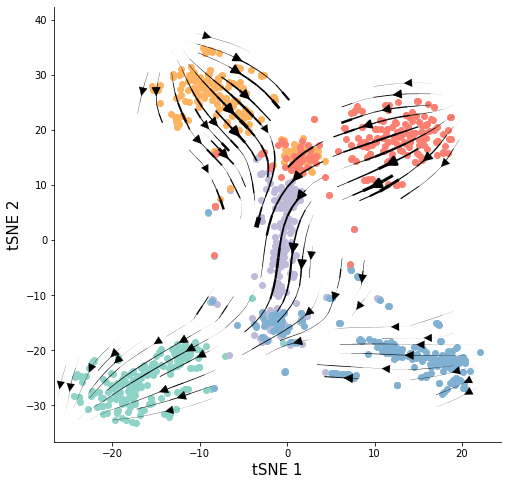

In [61]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.3, grid_density=25, radius=2, lw_coef=600, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Convergent model

In [ ]:
# tree_file = './Bifurcated/tree_origin_var0.02_rvg0.05.csv0'
# reconstruct('./Bifurcated/'+tree_file, output='./Linear/'+tree_file+'.nwk', num=1000, is_balance=True)

In [63]:
tree_file = './Convergent/tree_origin_converge.csv1.nwk'
phylo_tree, branch_colors = pv.ana_utils.loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = pv.sim_utils.get_annotation('./Convergent/tree_origin_converge.csv1')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

In [64]:
sd = pv.data_struct.scData(phylo_tree=phylo_tree, 
                            cell_states=cell_states.to_numpy().T[0].astype('int'), 
                            cell_generation=cell_generation.T[0].astype('int'),
                            cell_names=sampled_cells)

In [67]:
ge, base_expr = pv.sim_utils.sim_base_expr(sd.phylo_tree, 
                                             cell_states,
                                             Ngene=2000, 
                                             r_variant_gene=0.4, 
                                             diff_map={0:[0],1:[0],2:[0],3:[1],4:[2], 5:[3, 4]},
                                             pseudo_state_time={0:[0,5], 1:[7,12], 2:[7,12], 3:[13,18], 4:[13,18], 5:[19,24]},
                                             forward_map={3:5, 4:5},
                                             mu0_loc=0, 
                                             mu0_scale=1, 
                                             drift_loc=0, 
                                             drift_scale=0.3
                                          )

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  base_expr[cell.name] = ge.expr(


In [69]:
sd.count = pv.sim_utils.get_count_from_base_expr(pv.sim_utils.add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.05)
sd.dimensionality_reduction(method='tsne', scale=80, n_highly_variable_genes=0, perplexity=30, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(-45.0, 45.0)

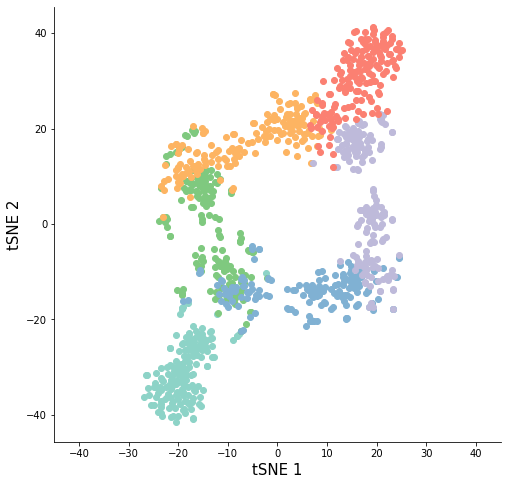

In [70]:
fig, ax = plt.subplots(figsize=(8, 8))
cmps = ['#8dd3c7','#7fc97f','#80b1d3','#fdb462','#bebada','#fb8072']
for i in range(6):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.set_xlim(-45, 45)

In [71]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

In [72]:
sd = pv.inference.velocity_inference(sd, sd.cell_generation, cutoff=0.9, target='count', exact=True)
sd = pv.embedding.velocity_embedding(sd, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:333: RuntimeWarning: invalid value encountered in log
  y = np.log(y + 1)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: divide by zero encountered in log
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in multiply
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)


(-45.0, 45.0)

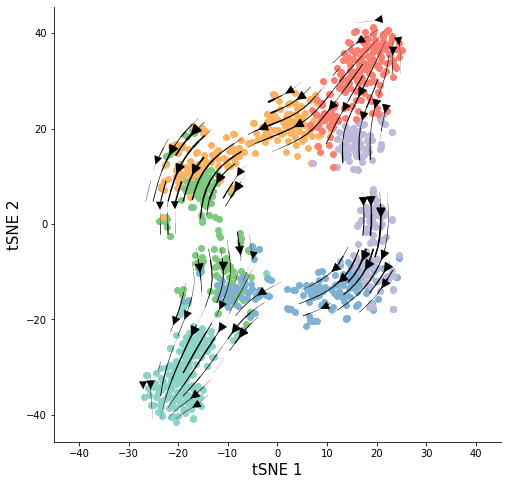

In [74]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#7fc97f','#80b1d3','#fdb462','#bebada','#fb8072']
for i in range(6):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.3, grid_density=25, radius=2, lw_coef=600, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-45, 45)